# 앙상블 주식 채권 비중별

- 투자 자산 : 주식(코스피200, SPY), 채권(20년 만기 국고채, TLT)
- 투자비율 : 다음과 같은 11개의 포트폴리오(투자 전략)를 만든다(매월 말 해당 비중대로 리밸런싱).
- 매월 말 11개 전략의 수익곡선 확인
  - 주식 100%~0% 채권 0~100%
- 각 수익곡선의 최근 '6개월 모멘텀(수익률) / 최근 6개월 수익률 변동성' 상위 n 개 포트폴리오를 선정
- 동일비중으로 투자
- 결과
  - 한국 그림 2-39
      - 코스피 10.0%/-47..0%
      - 20년 만기 국고채 13.0%/-20.7%
      - 전략 15.7%/-14.5%
  - 미국 그림 2-40
      - SPY 9.7%/-50.8%
      - TLT 6.3%/-21.8%
      - 전략 10.7%/-17.5%

## 요약
* 11의 전략은 월말에 리밸런싱하고 그 중에서 상위 3개 고르는 것은 월초에 리밸런싱한다. 이때 계산은 이전달 월말기준으로 한다.
  * spy, tlt비중은 직접 계산해야 한다.

In [1]:
from settings import *

In [2]:
tickers = ['SPY', 'TLT']
data = yf.download(tickers)['Adj Close']
data = data.dropna()
data.info()

[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2002-07-30 to 2022-02-17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4925 non-null   float64
 1   TLT     4925 non-null   float64
dtypes: float64(2)
memory usage: 115.4 KB


In [3]:
data['2002-7']

,SPY,TLT
Date,,
2002-07-30,62.377,42.148
2002-07-31,62.528,42.671


In [4]:
s = '2002-7-31'
# e = '2017-6-30'
e = '2022-2-17'
start = '2003-3-3'

In [5]:
data = data[s:]

In [6]:
data

,SPY,TLT
Date,,
2002-07-31,62.528,42.671
2002-08-01,60.895,42.914
2002-08-02,59.530,43.353
2002-08-05,57.459,43.544
2002-08-06,59.393,43.172
...,...,...
2022-02-11,440.460,138.250
2022-02-14,439.020,136.530
2022-02-15,446.100,134.980


In [7]:
def strategy(name, data, index, bond):
    s = bt.Strategy(name,
            [
                bt.algos.RunMonthly(run_on_end_of_period=True), #월말
                bt.algos.SelectAll(),
                bt.algos.WeighSpecified(SPY=index, TLT=bond),
                # PrintTempWeights(),
                bt.algos.Rebalance(),
            ])

    return bt.Backtest(s, data, initial_capital=100000000.0)

In [8]:
t1 = strategy("t1",   data, 1.0, 0.0)
t2 = strategy("t2",   data, 0.9, 0.1)
t3 = strategy("t3",   data, 0.8, 0.2)
t4 = strategy("t4",   data, 0.7, 0.3)
t5 = strategy("t5",   data, 0.6, 0.4)
t6 = strategy("t6",   data, 0.5, 0.5)
t7 = strategy("t7",   data, 0.4, 0.6)
t8 = strategy("t8",   data, 0.3, 0.7)
t9 = strategy("t9",   data, 0.2, 0.8)
t10 = strategy("t10", data, 0.1, 0.9)
t11 = strategy("t11", data, 0.0, 1.0)

In [9]:
r_all = bt.run(t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11)

In [10]:
r_all.display()

Stat                 t1          t2          t3          t4          t5          t6          t7          t8          t9          t10         t11
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30
End                  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17  2022-02-17
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         598.99%     574.87%     545.27%     511.05%     473.14%     432.52%     390.14%     346.95%     303.79%     261.44%     220.57%
Daily Sharpe         0.62        0.67        0.74        0.83        0.92        0.99        0.99     

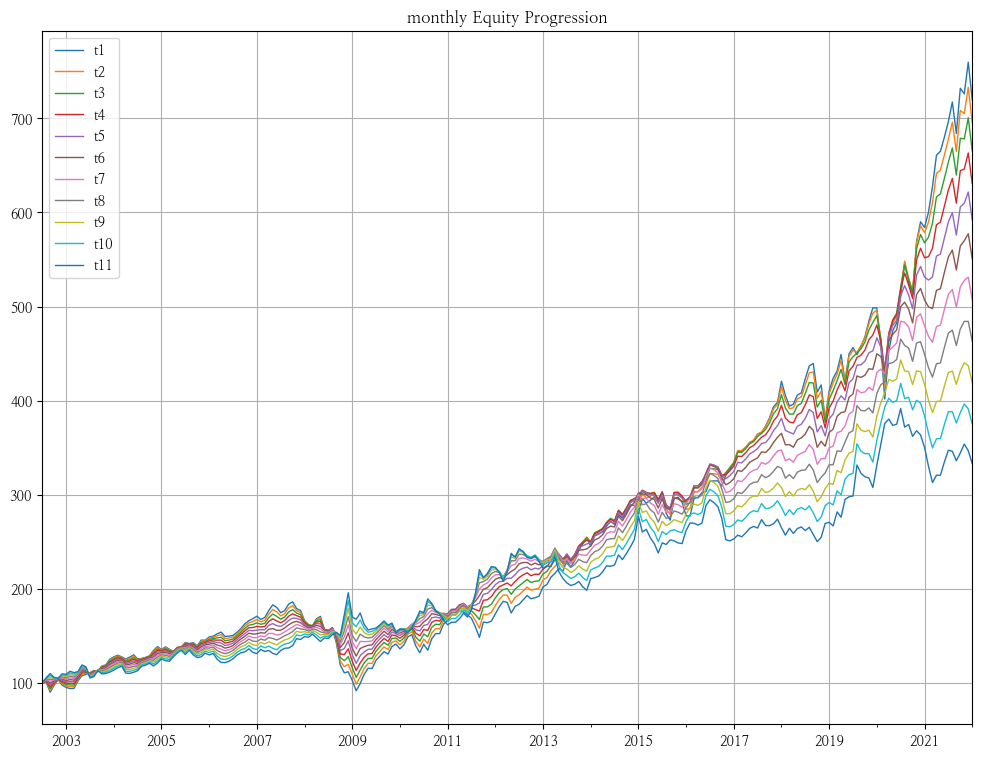

In [11]:
r_all.plot(freq='M', figsize=(12, 9));

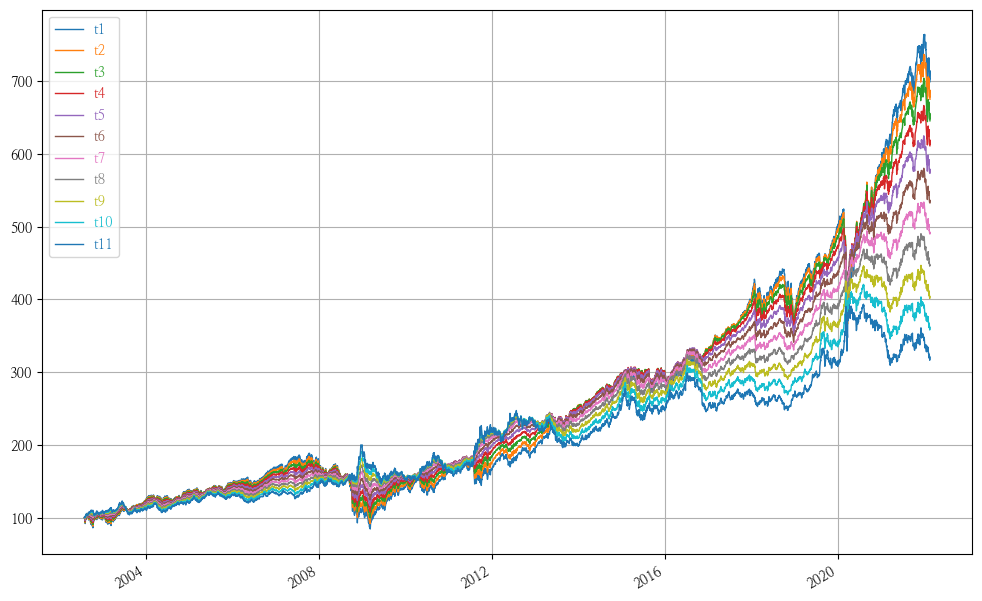

In [12]:
plot_df(r_all.prices, figsize=(12,9), logy=False)

In [13]:
class StatCalcRiskAdjustedReturn(bt.Algo):
    def __init__(self, lookback=6):
        super(StatCalcRiskAdjustedReturn, self).__init__()
        self.lookback = lookback

    def __call__(self, target):
        selected = target.temp['selected']

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()

        월별수익률 = prc.pct_change().dropna()
        변동성 = 월별수익률.std()

        모멘텀 = prc.calc_total_return()
        stats = 모멘텀/변동성
        print(f"=== {t0} {start} \n{prc}\n==월별수익률\n{월별수익률} \n==returns\n{모멘텀} \n==std\n{변동성}\nstats==\n{stats}\n")

        target.temp['stat'] = pd.Series(stats, index=prc.columns)

        return True

In [14]:
r_all.prices

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2002-07-30,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-07-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-08-01,97.389,97.707,98.025,98.343,98.661,98.979,99.297,99.615,99.933,100.251,100.569
2002-08-02,95.206,95.846,96.485,97.124,97.763,98.403,99.042,99.681,100.321,100.960,101.599
2002-08-05,91.893,92.909,93.924,94.940,95.955,96.971,97.986,99.001,100.017,101.032,102.048
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,704.424,680.312,650.659,616.329,578.260,537.428,494.805,451.327,407.864,365.195,323.994
2022-02-14,702.121,677.468,647.345,612.626,574.257,533.215,490.472,446.960,403.542,360.988,319.963
2022-02-15,713.444,686.559,654.272,617.512,577.267,534.547,490.347,445.612,401.207,357.897,316.330
2022-02-16,714.243,687.645,655.613,619.068,578.995,536.403,492.286,447.591,403.186,359.839,318.205


In [15]:
s

'2002-7-31'

In [16]:
data1  = r_all.prices[s:]
data1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2002-07-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-08-01,97.389,97.707,98.025,98.343,98.661,98.979,99.297,99.615,99.933,100.251,100.569
2002-08-02,95.206,95.846,96.485,97.124,97.763,98.403,99.042,99.681,100.321,100.960,101.599
2002-08-05,91.893,92.909,93.924,94.940,95.955,96.971,97.986,99.001,100.017,101.032,102.048
2002-08-06,94.987,95.606,96.224,96.843,97.462,98.081,98.700,99.319,99.938,100.556,101.175


In [17]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2003-03-02'

In [18]:
st = bt.Strategy("ensemble",
        [
            bt.algos.RunMonthly(run_on_end_of_period=False), #월초
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            StatCalcRiskAdjustedReturn(lookback=6),
            bt.algos.SelectN(3),
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)

In [19]:
bt_ensemble = bt.Backtest(st, data1, initial_capital=100000000.0)
r = bt.run(bt_ensemble)

=== 2003-02 2002-08 
                t1      t2      t3      t4      t5      t6      t7      t8  \
2002-08-31 100.680 101.163 101.647 102.130 102.613 103.097 103.580 104.063   
2002-09-30  90.124  92.048  93.986  95.939  97.906  99.887 101.883 103.892   
2002-10-31  97.539  98.524  99.479 100.402 101.293 102.152 102.978 103.770   
2002-11-30 103.556 103.903 104.205 104.461 104.670 104.834 104.952 105.025   
2002-12-31  97.697  99.084 100.432 101.742 103.012 104.241 105.427 106.570   
2003-01-31  95.295  96.833  98.341  99.815 101.255 102.659 104.026 105.354   
2003-02-28  94.010  95.959  97.889  99.801 101.690 103.557 105.398 107.212   

                t9     t10     t11  
2002-08-31 104.547 105.030 105.513  
2002-09-30 105.916 107.955 110.007  
2002-10-31 104.529 105.253 105.943  
2002-11-30 105.052 105.035 104.972  
2002-12-31 107.667 108.719 109.723  
2003-01-31 106.642 107.888 109.091  
2003-02-28 108.997 110.750 112.470  
==월별수익률
               t1     t2     t3     t4     t5     

In [20]:
r.set_date_range(start,e)
r.display()

Stat                 ensemble
-------------------  ----------
Start                2003-03-03
End                  2022-02-17
Risk-free rate       0.00%

Total Return         440.18%
Daily Sharpe         0.85
Daily Sortino        1.36
CAGR                 9.30%
Max Drawdown         -25.66%
Calmar Ratio         0.36

MTD                  -3.05%
3m                   -11.40%
6m                   -9.40%
YTD                  -9.96%
1Y                   2.20%
3Y (ann.)            9.50%
5Y (ann.)            7.33%
10Y (ann.)           9.31%
Since Incep. (ann.)  9.30%

Daily Sharpe         0.85
Daily Sortino        1.36
Daily Mean (ann.)    9.53%
Daily Vol (ann.)     11.18%
Daily Skew           -0.35
Daily Kurt           4.51
Best Day             4.31%
Worst Day            -5.37%

Monthly Sharpe       0.89
Monthly Sortino      1.70
Monthly Mean (ann.)  9.58%
Monthly Vol (ann.)   10.78%
Monthly Skew         0.09
Monthly Kurt         2.94
Best Month           12.40%
Worst Month          -12.58%



In [21]:
r.prices.resample('M').last().to_drawdown_series().min()

ensemble   -0.214
dtype: float64

<AxesSubplot:>

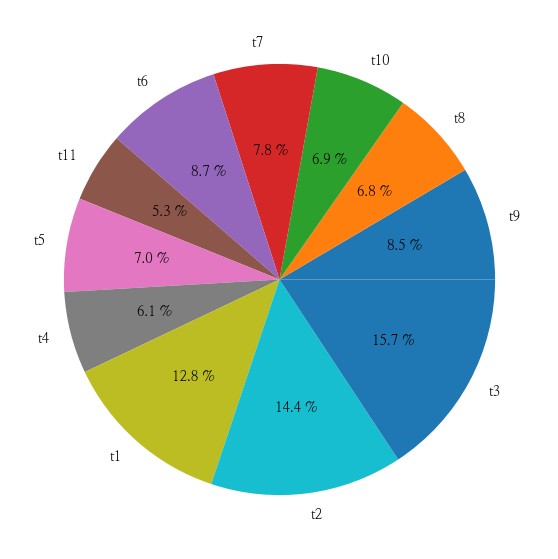

In [22]:
r.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(7,7))

In [23]:
w = r.get_security_weights()[start:]
w

,t9,t8,t10,t7,t6,t11,t5,t4,t1,t2,t3
2003-03-03,0.333,0.333,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2003-03-04,0.333,0.333,0.334,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2003-03-05,0.333,0.333,0.334,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2003-03-06,0.333,0.333,0.334,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2003-03-07,0.333,0.333,0.334,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.333,0.333
2022-02-14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.333,0.333
2022-02-15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.333,0.332
2022-02-16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.334,0.333,0.332


In [24]:
r_all.prices.columns

Index(['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11'], dtype='object')

In [25]:
weights = {}
for c in list(r_all.prices.columns):
    weights[c]= r_all.get_security_weights(c)

In [26]:
weights

{'t1':              SPY
 2002-07-30 0.000
 2002-07-31 1.000
 2002-08-01 1.000
 2002-08-02 1.000
 2002-08-05 1.000
 ...          ...
 2022-02-11 1.000
 2022-02-14 1.000
 2022-02-15 1.000
 2022-02-16 1.000
 2022-02-17 1.000
 
 [4925 rows x 1 columns],
 't2':              SPY   TLT
 2002-07-30 0.000 0.000
 2002-07-31 0.900 0.100
 2002-08-01 0.897 0.103
 2002-08-02 0.894 0.106
 2002-08-05 0.890 0.110
 ...          ...   ...
 2022-02-11 0.901 0.099
 2022-02-14 0.901 0.099
 2022-02-15 0.904 0.096
 2022-02-16 0.903 0.097
 2022-02-17 0.901 0.099
 
 [4925 rows x 2 columns],
 't3':              SPY   TLT
 2002-07-30 0.000 0.000
 2002-07-31 0.800 0.200
 2002-08-01 0.795 0.205
 2002-08-02 0.789 0.211
 2002-08-05 0.783 0.217
 ...          ...   ...
 2022-02-11 0.801 0.199
 2022-02-14 0.803 0.197
 2022-02-15 0.807 0.193
 2022-02-16 0.806 0.194
 2022-02-17 0.802 0.198
 
 [4925 rows x 2 columns],
 't4':              SPY   TLT
 2002-07-30 0.000 0.000
 2002-07-31 0.700 0.300
 2002-08-01 0.693 0.307
 200

In [27]:
weights['t1']['TLT']  = 0

In [28]:
weights['t1']

,SPY,TLT
2002-07-30,0.000,0
2002-07-31,1.000,0
2002-08-01,1.000,0
2002-08-02,1.000,0
2002-08-05,1.000,0
...,...,...
2022-02-11,1.000,0
2022-02-14,1.000,0
2022-02-15,1.000,0
2022-02-16,1.000,0


In [29]:
weights['t11']['SPY'] = 0
weights['t11']

,TLT,SPY
2002-07-30,0.000,0
2002-07-31,1.000,0
2002-08-01,1.000,0
2002-08-02,1.000,0
2002-08-05,1.000,0
...,...,...
2022-02-11,1.000,0
2022-02-14,1.000,0
2022-02-15,1.000,0
2022-02-16,1.000,0


<AxesSubplot:>

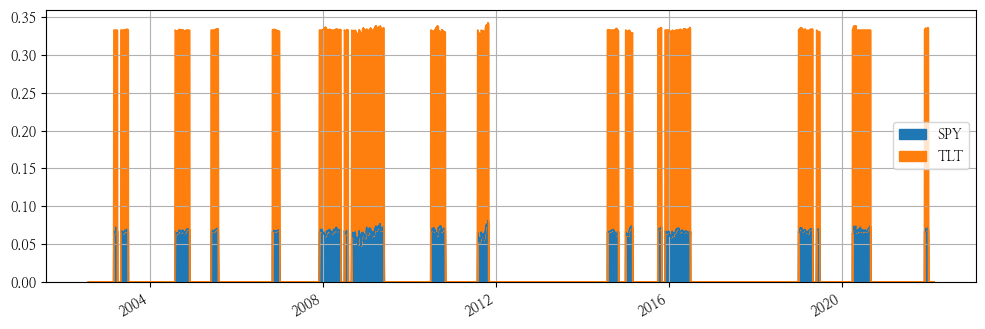

In [30]:
weights['t9'].mul(w['t9'], axis=0).plot.area(figsize=(12,4))

In [31]:
weights['t1'].add(weights['t2'], axis=0)

,SPY,TLT
2002-07-30,0.000,0.000
2002-07-31,1.900,0.100
2002-08-01,1.897,0.103
2002-08-02,1.894,0.106
2002-08-05,1.890,0.110
...,...,...
2022-02-11,1.901,0.099
2022-02-14,1.901,0.099
2022-02-15,1.904,0.096
2022-02-16,1.903,0.097


In [32]:
w1 = weights['t2'] * 0.0
w1

,SPY,TLT
2002-07-30,0.000,0.000
2002-07-31,0.000,0.000
2002-08-01,0.000,0.000
2002-08-02,0.000,0.000
2002-08-05,0.000,0.000
...,...,...
2022-02-11,0.000,0.000
2022-02-14,0.000,0.000
2022-02-15,0.000,0.000
2022-02-16,0.000,0.000


In [33]:
for c in list(r_all.prices.columns):
    w1 += weights[c].mul(w[c], axis=0)

In [34]:
w1.dropna()

,SPY,TLT
2003-03-03,0.198,0.802
2003-03-04,0.196,0.804
2003-03-05,0.197,0.803
2003-03-06,0.196,0.804
2003-03-07,0.196,0.804
...,...,...
2022-02-11,0.901,0.099
2022-02-14,0.901,0.099
2022-02-15,0.904,0.096
2022-02-16,0.903,0.097


<AxesSubplot:>

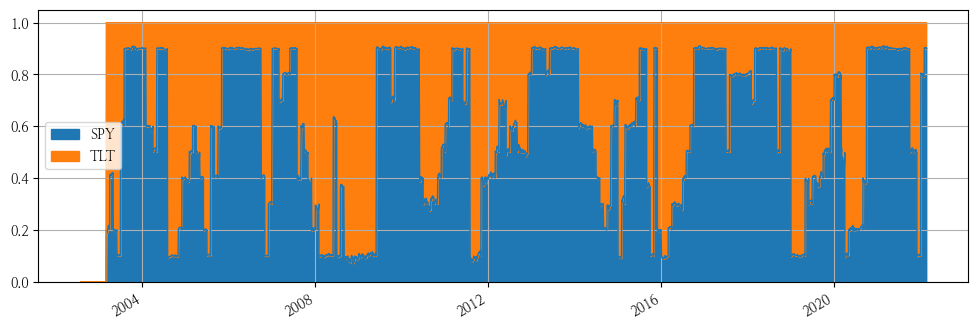

In [35]:
w1.plot.area(figsize=(12, 4))

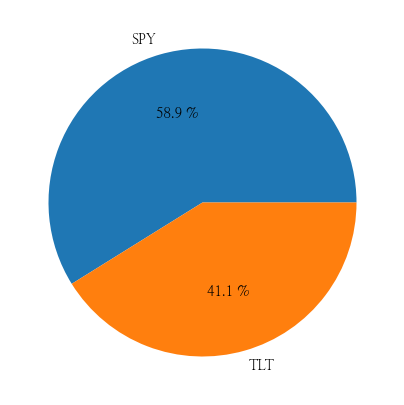

In [36]:
w1.dropna().sum().plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

In [37]:
bt_spy = long_only_ew(data, ['SPY'], 'SPY')
bt_tlt = long_only_ew(data, ['TLT'], 'TLT')

r_spy = bt.run(bt_spy)
r_tlt  = bt.run(bt_tlt)

2002-07-31 00:00:00
2002-07-31 00:00:00


In [38]:
st_ew = bt.Strategy("ew",
        [
            bt.algos.RunMonthly(run_on_end_of_period=True),
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)
bt_ew = bt.Backtest(st_ew, data, initial_capital=100000000.0)
r_ew = bt.run(bt_ew)

2003-03-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-04-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-05-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-06-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-07-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-08-29 00:00:00 ew SPY:0.500 TLT:0.500 
2003-09-30 00:00:00 ew SPY:0.500 TLT:0.500 
2003-10-31 00:00:00 ew SPY:0.500 TLT:0.500 
2003-11-28 00:00:00 ew SPY:0.500 TLT:0.500 
2003-12-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-01-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-02-27 00:00:00 ew SPY:0.500 TLT:0.500 
2004-03-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-04-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-05-28 00:00:00 ew SPY:0.500 TLT:0.500 
2004-06-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-07-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-08-31 00:00:00 ew SPY:0.500 TLT:0.500 
2004-09-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-10-29 00:00:00 ew SPY:0.500 TLT:0.500 
2004-11-30 00:00:00 ew SPY:0.500 TLT:0.500 
2004-12-31 00:00:00 ew SPY:0.500 TLT:0.500 
2005-01-31 00:00:00 ew SPY:0.500

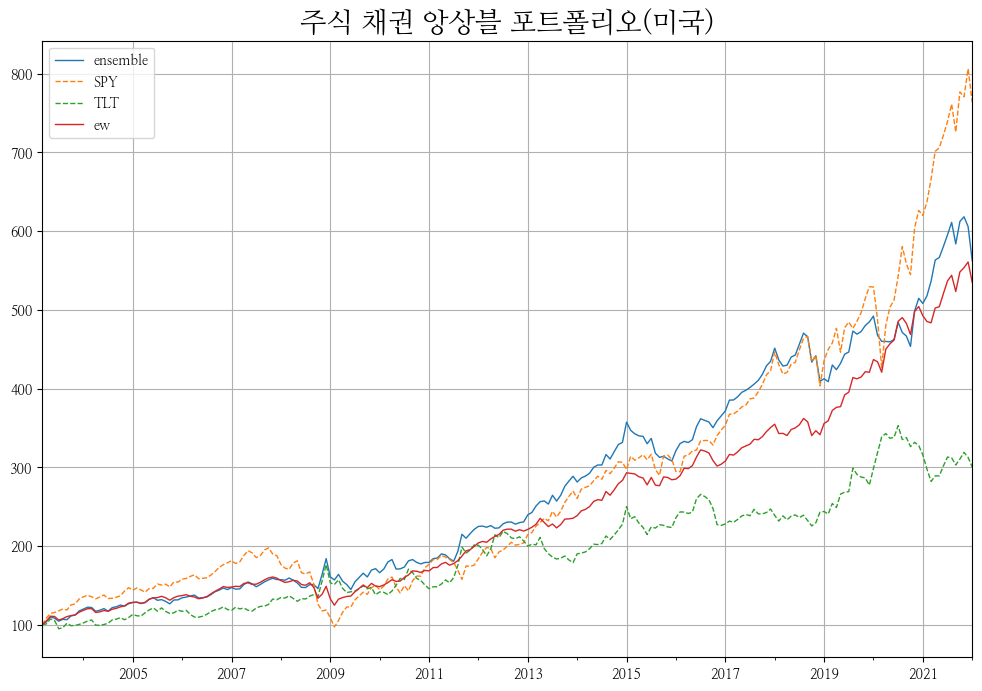

In [39]:
r_spy.set_date_range(start,e)
r_tlt.set_date_range(start,e)
r_ew.set_date_range(start,e)

ax1 = r.plot(freq='M', figsize=(12,8));
r_spy.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_tlt.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_ew.plot(ax=ax1, freq='M', ls='-', figsize=(12,8));
plt.title("주식 채권 앙상블 포트폴리오(미국)", fontsize=20);

In [40]:
r_asset = bt.run(bt_spy, bt_tlt, bt_ew, bt_ensemble)
r_asset.set_date_range(start, e)
r_asset.display()

Stat                 SPY         TLT         ew          ensemble
-------------------  ----------  ----------  ----------  ----------
Start                2003-03-03  2003-03-03  2003-03-03  2003-03-03
End                  2022-02-17  2022-02-17  2022-02-17  2022-02-17
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         650.68%     184.68%     417.20%     440.18%
Daily Sharpe         0.66        0.47        1.01        0.85
Daily Sortino        1.02        0.78        1.62        1.36
CAGR                 11.22%      5.67%       9.05%       9.30%
Max Drawdown         -55.19%     -26.59%     -24.67%     -25.66%
Calmar Ratio         0.20        0.21        0.37        0.36

MTD                  -2.86%      -3.80%      -3.33%      -3.05%
3m                   -6.31%      -6.13%      -6.16%      -11.40%
6m                   -0.91%      -7.41%      -4.11%      -9.40%
YTD                  -7.98%      -7.56%      -7.77%      -9.96%
1Y                   12.87%  

In [41]:
r_asset.prices.resample('M').last().to_drawdown_series().min()

SPY        -0.508
TLT        -0.218
ew         -0.223
ensemble   -0.214
dtype: float64

In [42]:
def plot_assets(backtest_result, start, end, strategy_name, weights, **kwargs):
    res1 = backtest_result
    start = start
    end = end
    plt.rcParams["figure.figsize"] = [16, 12]
    plt.subplots_adjust(hspace=0)

    color_dict = kwargs.pop('color_dict', None)

    # 첫번째 칸에 그림을 그린다.
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
    # 두개를 한 칸에 그리기 위해 ax=ax1으로 axis공유
    if color_dict:
        color = [color_dict.get(x, "#333333") for x in res1.prices.columns]
        ax2 = res1.prices[start:end].rebase(1).plot(ax=ax1, lw=1, color=color, logy=True, **kwargs) # 모든 데이터 r_all
    else:
        ax2 = res1.prices[start:end].rebase(1).plot(ax=ax1, lw=1, logy=True, **kwargs) # 모든 데이터 r_all
    for line in ax2.get_lines():
        if line.get_label() == strategy_name:
            line.set_linewidth(3)
    plt.legend(loc="upper left");
    plt.title(strategy_name, fontsize=20)
    weights[start:end].plot.area(alpha=0.2, ax=ax1, secondary_y=True, **kwargs)


    # 두번째 칸에 그림을 그린다.
    # drawdown을 그림다. 두개를 하나에 그리기 위해 ax=ax2로 axis를 공유
    ax2 = plt.subplot2grid((3,1), (2,0))
    if color_dict:
        color = [color_dict.get(x, "#333333") for x in res1.prices.columns]
        res1.prices[start:end].to_drawdown_series().plot.area(stacked=False, color=color, legend=True, ax=ax2, **kwargs)
    else:
        res1.prices[start:end].to_drawdown_series().plot.area(stacked=False,legend=True, ax=ax2, **kwargs)
    res1.prices.loc[start:end,strategy_name].to_drawdown_series().plot(legend=False, color='black', alpha=1, lw=1, ls='-', ax=ax2)

    print(res1.prices[start:end].calc_cagr().to_frame().rename(columns={0: "CAGR"})*100)
    print(res1.prices[start:end].calc_max_drawdown().to_frame().rename(columns={0: "MDD"})*100)


           CAGR
SPY      11.216
TLT       5.672
ew        9.053
ensemble  9.303
             MDD
SPY      -55.189
TLT      -26.585
ew       -24.675
ensemble -25.662


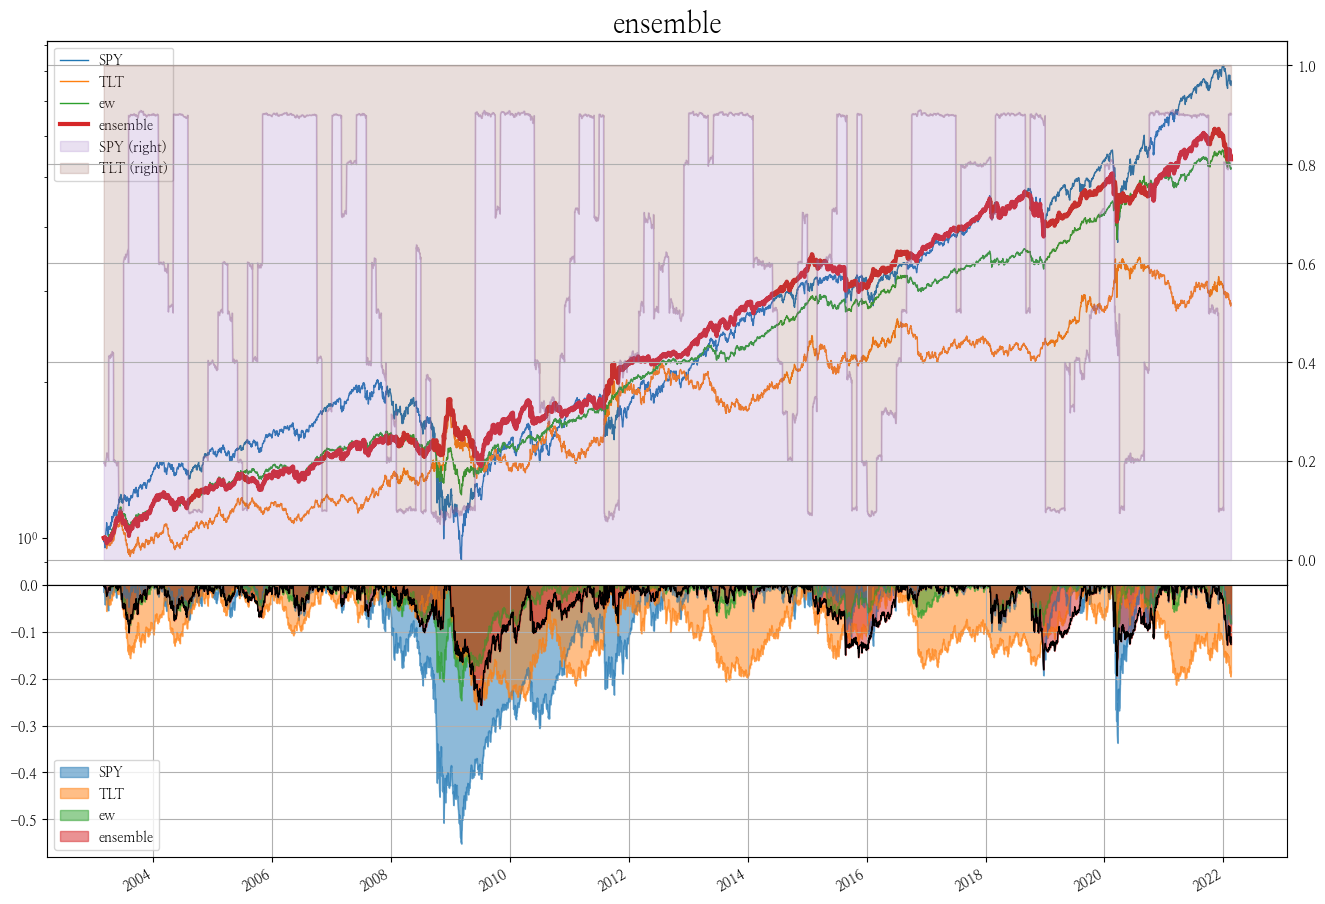

In [43]:
plot_assets(r_asset, start, e, 'ensemble', w1)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2003-03-04  2003-03-04
End Period                 2022-02-17  2022-02-17
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          440.18%     650.68%
CAGR﹪                     9.3%        11.21%

Sharpe                     0.85        0.66
Smart Sharpe               0.85        0.66
Sortino                    1.2         0.93
Smart Sortino              1.2         0.93
Sortino/√2                 0.85        0.66
Smart Sortino/√2           0.85        0.66
Omega                      1.16        1.16

Max Drawdown               -25.66%     -55.19%
Longest DD Days            846         1772
Volatility (ann.)          11.18%      18.8%
R^2                        0.12        0.12
Calmar                     0.36        0.2
Skew                       -0.35       -0.07
Kurtosis                   4.51        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-12-31,2009-07-07,2011-04-26,846,-25.662,-24.399
2,2020-02-20,2020-03-18,2020-12-28,312,-19.393,-15.383
3,2018-08-30,2018-12-24,2019-08-29,364,-18.126,-14.595
4,2015-02-02,2015-11-13,2016-07-06,520,-15.509,-14.403
5,2021-11-10,2022-01-27,2022-02-17,99,-12.862,-12.851


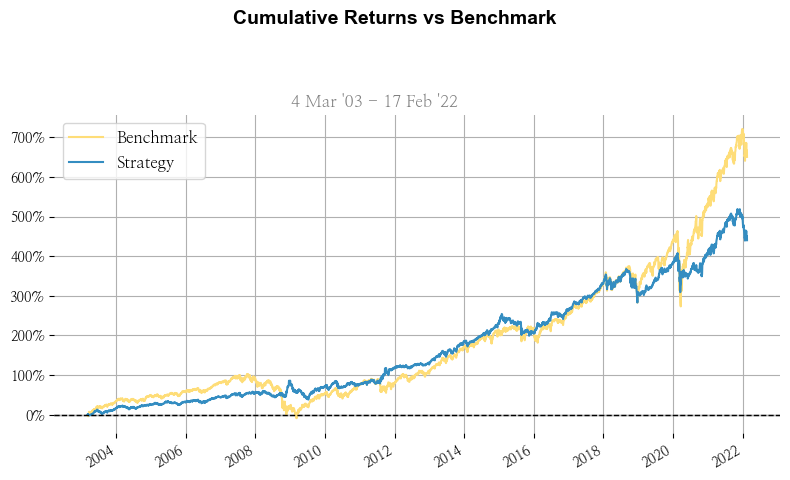

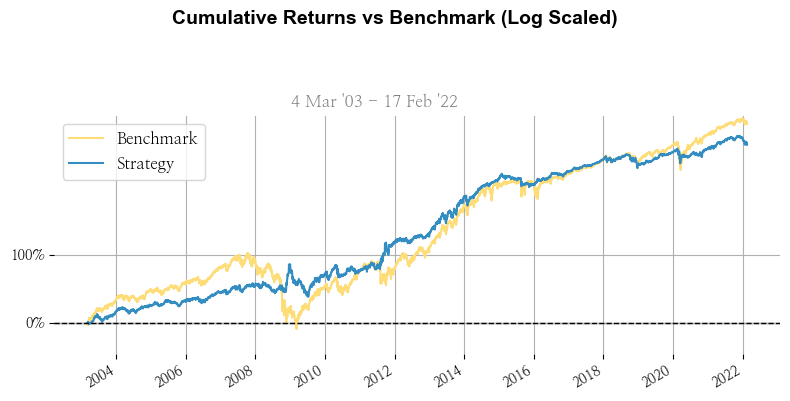

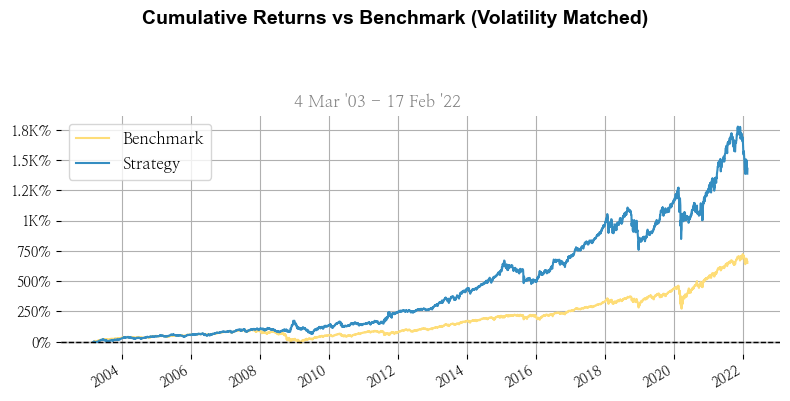

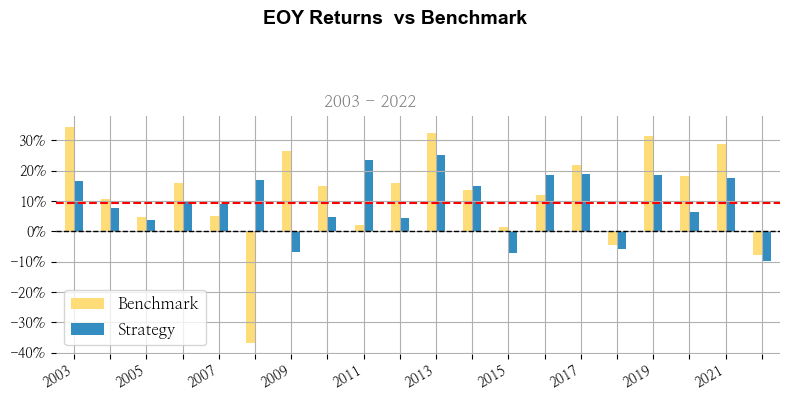

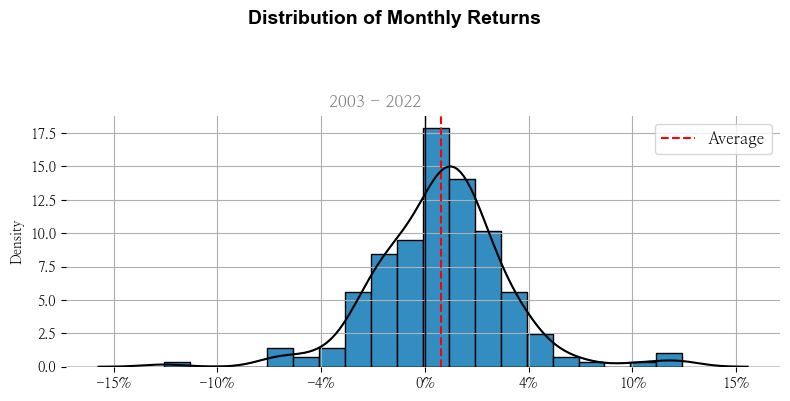

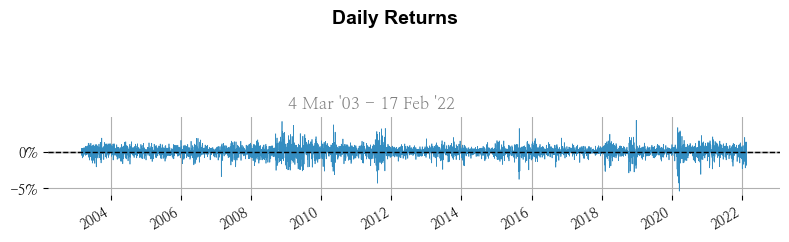

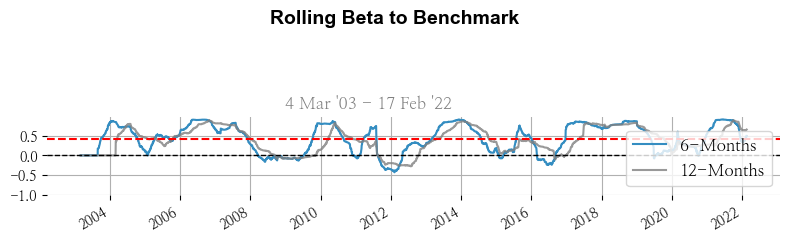

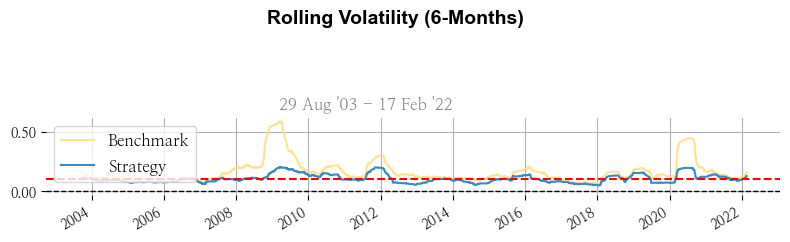

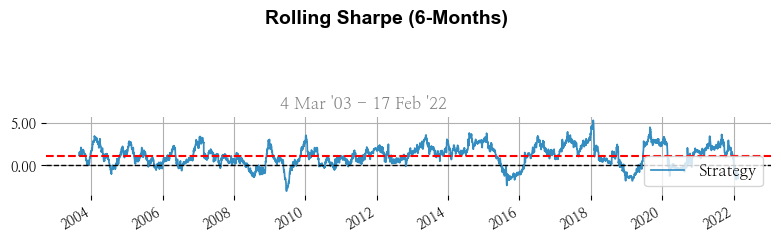

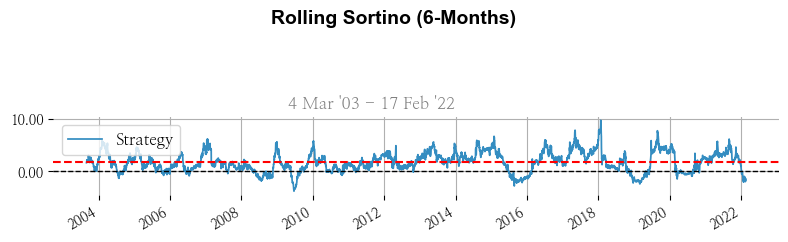

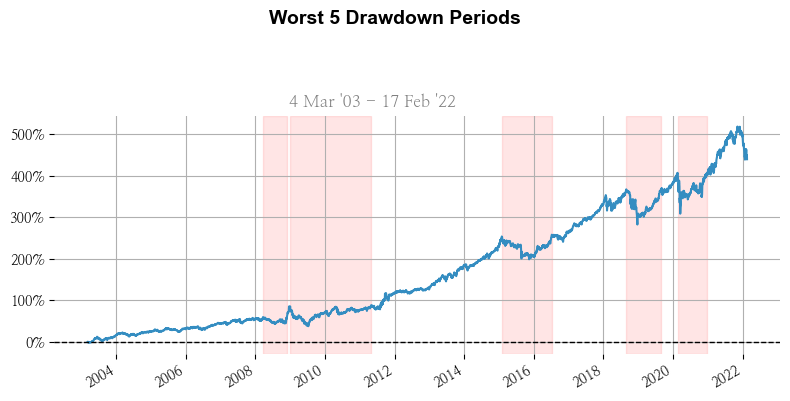

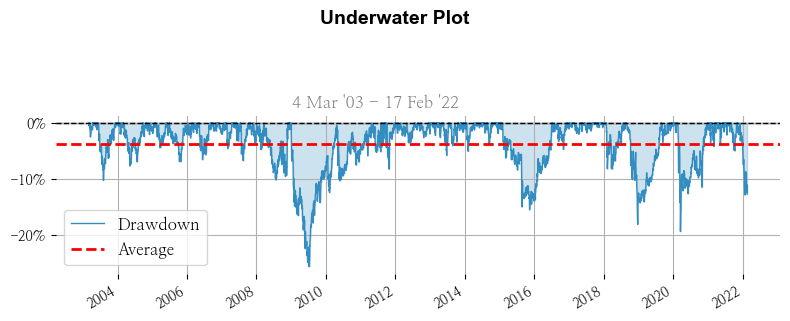

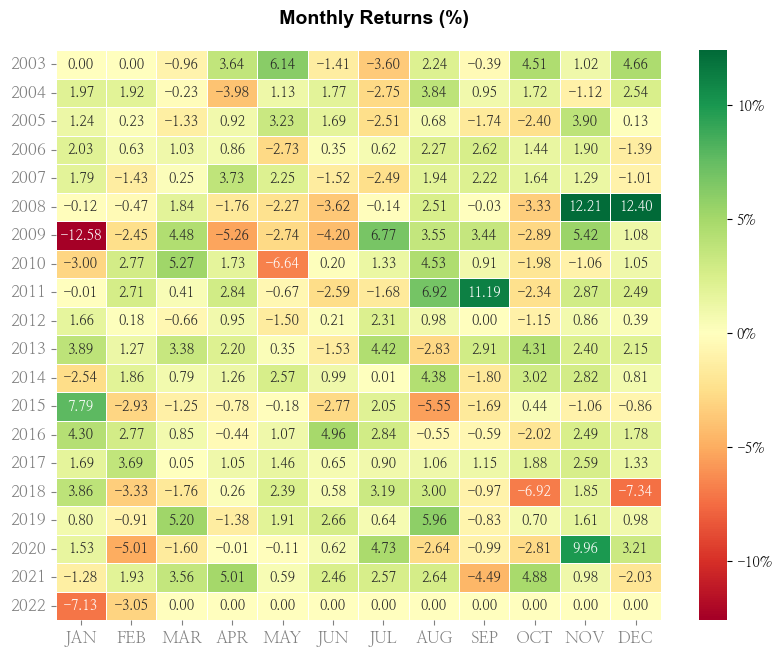

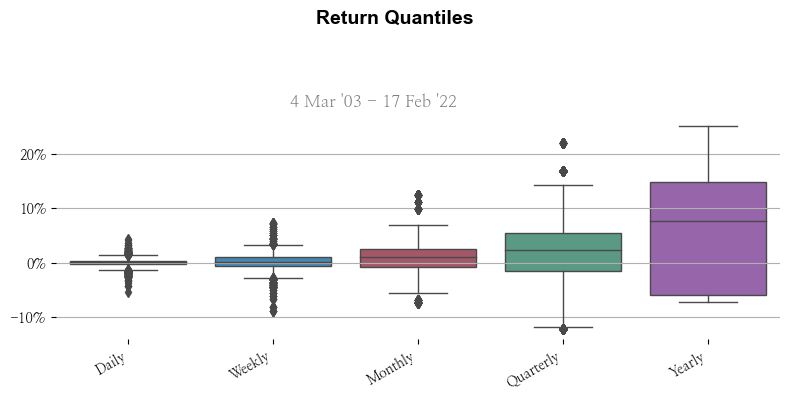

In [44]:
qs.reports.full(r.prices.loc[start:e, 'ensemble'].pct_change().dropna(), 
                r_spy.prices.loc[start:e, 'SPY'].pct_change().dropna())